In [1]:
import os
import pickle
import gzip
import numpy as np
from sklearn import naive_bayes
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [2]:
col_names = ["polarity", "id", "date", "query", "user", "text"]

In [3]:
train_data_file = 'data/trainingandtestdata/training.1600000.processed.noemoticon.csv'
test_data_file = 'data/trainingandtestdata/testdata.manual.2009.06.14.csv'

In [5]:
train_dataset = pd.read_csv(
            train_data_file,
            names=col_names,
        )

In [6]:
train_dataset.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
train_dataset.describe() #include='all'

,polarity,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [14]:
from pandas.plotting import scatter_matrix
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d408590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1109a0d50>]], dtype=object)

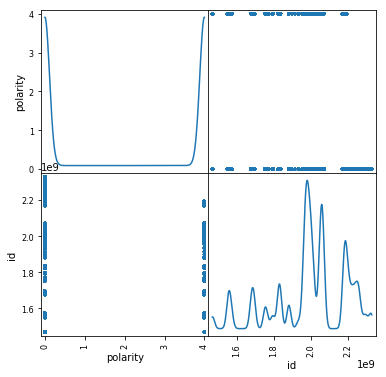

In [15]:
scatter_matrix(train_dataset, alpha=0.2, figsize=(6, 6), diagonal='kde');

### Model Training

In [16]:
def train_vectorizer(corpus, max_features=10000):
    """ Train the vectorizer """
    print "training the vectorizer..."
    vectorizer = CountVectorizer(decode_error='ignore', max_features=max_features)
    vectorizer.fit(corpus)
    print "ok"
    return vectorizer

In [17]:
def extract_features(vectorizer, text):
    """ Extract text features """
    return vectorizer.transform(text)

In [18]:
def train_model(dataset):
    """ Train a new model """
    text_train = dataset.text
    vectorizer = train_vectorizer(text_train)
    vectorizer.stop_words_ = set({})
    print "extracting features..."
    x_train = extract_features(vectorizer, text_train)
    y_train = dataset.polarity
    model = naive_bayes.MultinomialNB()
    print "training the model..."
    model.fit(x_train, y_train)
    model.vectorizer = vectorizer
    return model

In [20]:
model = train_model(train_dataset)

training the vectorizer...
ok
extracting features...
training the model...


#### ... the feature vector is a scipy sparse vector

## Testing

In [22]:
def test_model(model, dataset):
    """ Test the given model (confusion matrix) """
    print "testing the model..."
    text_test = dataset.text
    x_test = extract_features(model.vectorizer, text_test)
    y_test = dataset.polarity
    y_predicted = model.predict(x_test)
    cmat = confusion_matrix(y_test, y_predicted)
    print np.around(cmat / cmat.astype(np.float).sum(axis=1) / 0.01)
    print "accuracy: %.3f" % (float(np.trace(cmat)) / float(np.sum(cmat)))

In [23]:
test_dataset = pd.read_csv(
        test_data_file,
        names=col_names,
    )

#### remove 1 class, leaving us with two classes

In [24]:
test_dataset = test_dataset[test_dataset.polarity != 2]

### Evaluation Metrics : The Confusion Matrix, and overall Accuracy

In [25]:
test_model(model, test_dataset)

testing the model...
[[ 81.  18.]
 [ 19.  82.]]
accuracy: 0.816


## Persist the model

In [26]:
model_filename = "data/model.dat.gz"
pickle.dump(model, gzip.open(model_filename, "wb"))

## Load the Model

In [27]:
loaded_model = pickle.load(gzip.open(model_filename, "rb"))

In [28]:
loaded_model

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Make New Predictions

In [31]:
CLASSES = {
    0: "negative",
    4: "positive"
}

In [35]:
def predict(model, text):
    """ Predict class given model and input (text) """
    print "Extracting features..."
    x_vector = model.vectorizer.transform([text])
    y_predicted = model.predict(x_vector)
    return CLASSES.get(y_predicted[0])

In [38]:
neg_test = predict(loaded_model, 'I am happy, this is excellent')

Extracting features...


In [39]:
pos_test = predict(loaded_model, 'This is so bad, I hate it')

Extracting features...


In [40]:
neutral_test = predict(loaded_model, "I am neutral about this")

Extracting features...


In [41]:
print(neg_test, pos_test, neutral_test)

('positive', 'negative', 'negative')
